In [1]:
####
#scaling data
####
#!/usr/bin/env python
# encoding: utf-8

r"""
Low-level routines for finite-size scaling analysis

See Also
--------

fssa : The high-level module

Notes
-----

The **fssa** package provides routines to perform finite-size scaling analyses
on experimental data [10]_ [11]_.

It has been inspired by Oliver Melchert and his superb **autoScale** package
[3]_.

References
----------

.. [10] M. E. J. Newman and G. T. Barkema, Monte Carlo Methods in Statistical
   Physics (Oxford University Press, 1999)

.. [11] K. Binder and D. W. Heermann, `Monte Carlo Simulation in Statistical
   Physics <http://dx.doi.org/10.1007/978-3-642-03163-2>`_ (Springer, Berlin,
   Heidelberg, 2010)

.. [3] O. Melchert, `arXiv:0910.5403 <http://arxiv.org/abs/0910.5403>`_
   (2009)

"""

# Python 2/3 compatibility
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import warnings
from builtins import *
from collections import namedtuple

import numpy as np
import numpy.ma as ma
import scipy.optimize

#from .optimize import _minimize_neldermead


class ScaledData(namedtuple('ScaledData', ['x', 'y', 'dy'])):
    """
    A :py:func:`namedtuple <collections.namedtuple>` for :py:func:`scaledata`
    output
    """

    # set this to keep memory requirements low, according to
    # http://docs.python.org/3/library/collections.html#namedtuple-factory-function-for-tuples-with-named-fields
    __slots__ = ()

def scaledata3(l, rho, a, da, rho_c, nu, zeta, omega, acst, omega2, acst2):
    r'''
    Scale experimental data according to critical exponents

    Parameters
    ----------
    l, rho : 1-D array_like
       finite system sizes `l` and parameter values `rho`

    a, da : 2-D array_like of shape (`l`.size, `rho`.size)
       experimental data `a` with standard errors `da` obtained at finite
       system sizes `l` and parameter values `rho`, with
       ``a.shape == da.shape == (l.size, rho.size)``

    rho_c : float in range [rho.min(), rho.max()]
       (assumed) critical parameter value with ``rho_c >= rho.min() and rho_c
       <= rho.max()``

    nu, zeta : float
       (assumed) critical exponents

    Returns
    -------
    :py:class:`ScaledData`
       scaled data `x`, `y` with standard errors `dy`

    x, y, dy : ndarray
       two-dimensional arrays of shape ``(l.size, rho.size)``

    Notes
    -----
    Scale data points :math:`(\varrho_j, a_{ij}, da_{ij})` observed at finite
    system sizes :math:`L_i` and parameter values :math:`\varrho_i` according
    to the finite-size scaling ansatz

    .. math::

       L^{-\zeta/\nu} a_{ij} = \tilde{f}\left( L^{1/\nu} (\varrho_j -
       \varrho_c) \right).

    The output is the scaled data points :math:`(x_{ij}, y_{ij}, dy_{ij})` with

    .. math::

       x_{ij} & = L_i^{1/\nu} (\varrho_j - \varrho_c) \\
       y_{ij} & = L_i^{-\zeta/\nu} a_{ij} \\
       dy_{ij} & = L_i^{-\zeta/\nu} da_{ij}

    such that all data points :ref:`collapse <data-collapse-method>` onto the
    single curve :math:`\tilde{f}(x)` with the right choice of
    :math:`\varrho_c, \nu, \zeta` [4]_ [5]_.

    Raises
    ------
    ValueError
       If `l` or `rho` is not 1-D array_like, if `a` or `da` is not 2-D
       array_like, if the shape of `a` or `da` differs from ``(l.size,
       rho.size)``

    References
    ----------

    .. [4] M. E. J. Newman and G. T. Barkema, Monte Carlo Methods in
       Statistical Physics (Oxford University Press, 1999)

    .. [5] K. Binder and D. W. Heermann, `Monte Carlo Simulation in Statistical
       Physics <http://dx.doi.org/10.1007/978-3-642-03163-2>`_ (Springer,
       Berlin, Heidelberg, 2010)
    '''

    # l should be 1-D array_like
    l = np.asanyarray(l)
    if l.ndim != 1:
        raise ValueError("l should be 1-D array_like")

    # rho should be 1-D array_like
    rho = np.asanyarray(rho)
    if rho.ndim != 1:
        raise ValueError("rho should be 1-D array_like")

    # a should be 2-D array_like
    a = np.asanyarray(a)
    if a.ndim != 2:
        raise ValueError("a should be 2-D array_like")

    # a should have shape (l.size, rho.size)
    if a.shape != (l.size, rho.size):
        raise ValueError("a should have shape (l.size, rho.size)")

    # da should be 2-D array_like
    da = np.asanyarray(da)
    if da.ndim != 2:
        raise ValueError("da should be 2-D array_like")

    # da should have shape (l.size, rho.size)
    if da.shape != (l.size, rho.size):
        raise ValueError("da should have shape (l.size, rho.size)")

    # rho_c should be float
    rho_c = float(rho_c)
    

    # rho_c should be in range
    if rho_c > rho.max() or rho_c < rho.min():
        warnings.warn("rho_c is out of range", RuntimeWarning)

    # nu should be float
    nu = float(nu)

    # zeta should be float
    zeta = float(zeta)

    l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')
    
    nu0 = 5/6
    rho_c0 = 1.202

    x = (1.0/(1.0 + acst2 * np.power(l_mesh, - omega2) ) ) * np.power(l_mesh, 1. / nu) * (rho_mesh - rho_c)
    y = (1.0/(1.0 + acst * np.power(l_mesh, - omega) ) ) * np.power(l_mesh, - zeta / nu) * a
    dy = (1.0/(1.0 + acst * np.power(l_mesh, - omega) ) ) * np.power(l_mesh, - zeta / nu) * da
    
    #y = (1.0/(1.0 + acst * np.power(l_mesh, - omega) ) ) * np.power(l_mesh, - zeta ) * a
    #dy = (1.0/(1.0 + acst * np.power(l_mesh, - omega) ) ) * np.power(l_mesh, - zeta) * da

    return ScaledData(x, y, dy)


def _wls_linearfit_predict(x, w, wx, wy, wxx, wxy, select):
    """
    Predict a point according to a weighted least squares linear fit of the
    data

    This function is a helper function for :py:func:`quality`. It is not
    supposed to be called directly.

    Parameters
    ----------
    x : float
        The position for which to predict the function value

    w : ndarray
        The pre-calculated weights :math:`w_l`

    wx : ndarray
        The pre-calculated weighted `x` data :math:`w_l x_l`

    wy : ndarray
        The pre-calculated weighted `y` data :math:`w_l y_l`

    wxx : ndarray
    The pre-calculated weighted :math:`x^2` data :math:`w_l x_l^2`

    wxy : ndarray
        The pre-calculated weighted `x y` data :math:`w_l x_l y_l`

    select : indexing array
        To select the subset from the `w`, `wx`, `wy`, `wxx`, `wxy` data

    Returns
    -------
    float, float
        The estimated value of the master curve for the selected subset and the
        squared standard error
    """

    # linear fit
    k = w[select].sum()
    kx = wx[select].sum()
    ky = wy[select].sum()
    kxx = wxx[select].sum()
    kxy = wxy[select].sum()
    delta = k * kxx - kx ** 2
    m = 1. / delta * (k * kxy - kx * ky)
    b = 1. / delta * (kxx * ky - kx * kxy)
    b_var = kxx / delta
    m_var = k / delta
    bm_covar = - kx / delta

    # estimation
    y = b + m * x
    dy2 = b_var + 2 * bm_covar * x + m_var * x**2

    return y, dy2


def _jprimes(x, i, x_bounds=None):
    """
    Helper function to return the j' indices for the master curve fit

    This function is a helper function for :py:func:`quality`. It is not
    supposed to be called directly.

    Parameters
    ----------
    x : mapping to ndarrays
        The x values.

    i : int
        The row index (finite size index)

    x_bounds : 2-tuple, optional
        bounds on x values

    Returns
    -------
    ret : mapping to ndarrays
        Has the same keys and shape as `x`.
        Its element ``ret[i'][j]`` is the j' such that :math:`x_{i'j'} \leq
        x_{ij} < x_{i'(j'+1)}`.
        If no such j' exists, the element is np.nan.
        Convert the element to int to use as an index.
    """

    j_primes = - np.ones_like(x)

    try:
        x_masked = ma.masked_outside(x, x_bounds[0], x_bounds[1])
    except (TypeError, IndexError):
        x_masked = ma.asanyarray(x)

    k, n = x.shape

    # indices of lower and upper bounds
    edges = ma.notmasked_edges(x_masked, axis=1)
    x_lower = np.zeros(k, dtype=int)
    x_upper = np.zeros(k, dtype=int)
    x_lower[edges[0][0]] = edges[0][-1]
    x_upper[edges[-1][0]] = edges[-1][-1]

    for i_prime in range(k):
        if i_prime == i:
            j_primes[i_prime][:] = np.nan
            continue

        jprimes = np.searchsorted(
            x[i_prime], x[i], side='right'
        ).astype(float) - 1
        jprimes[
            np.logical_or(
                jprimes < x_lower[i_prime],
                jprimes >= x_upper[i_prime]
            )
        ] = np.nan
        j_primes[i_prime][:] = jprimes

    return j_primes


def _select_mask(j, j_primes):
    """
    Return a boolean mask for selecting the data subset according to the j'

    Parameters
    ----------
    j : int
        current j index

    j_primes : ndarray
        result from _jprimes call
    """

    ret = np.zeros_like(j_primes, dtype=bool)
    my_iprimes = np.invert(np.isnan(j_primes[:, j])).nonzero()[0]
    my_jprimes = j_primes[my_iprimes, j]
    my_jprimes = my_jprimes.astype(np.int)
    ret[my_iprimes, my_jprimes] = True
    ret[my_iprimes, my_jprimes + 1] = True

    return ret


def quality(x, y, dy, x_bounds=None):
    r'''
    Quality of data collapse onto a master curve defined by the data

    This is the reduced chi-square statistic for a data fit except that the
    master curve is fitted from the data itself.

    Parameters
    ----------
    x, y, dy : 2-D array_like
        output from :py:func:`scaledata`, scaled data `x`, `y` with standard
        errors `dy`

    x_bounds : tuple of floats, optional
        lower and upper bound for scaled data `x` to consider

    Returns
    -------
    float
        the quality of the data collapse

    Raises
    ------
    ValueError
        if not all arrays `x`, `y`, `dy` have dimension 2, or if not all arrays
        are of the same shape, or if `x` is not sorted along rows (``axis=1``),
        or if `dy` does not have only positive entries

    Notes
    -----
    This is the implementation of the reduced :math:`\chi^2` quality function
    :math:`S` by Houdayer & Hartmann [6]_.
    It should attain a minimum of around :math:`1` for an optimal fit, and be
    much larger otherwise.

    For further information, see the :ref:`quality-function` section in the
    manual.

    References
    ----------
    .. [6] J. Houdayer and A. Hartmann, Physical Review B 70, 014418+ (2004)
        `doi:10.1103/physrevb.70.014418
        <http://dx.doi.org/doi:10.1103/physrevb.70.014418>`_

    '''

    # arguments should be 2-D array_like
    x = np.asanyarray(x)
    y = np.asanyarray(y)
    dy = np.asanyarray(dy)

    args = {"x": x, "y": y, "dy": dy}
    for arg_name, arg in args.items():
        if arg.ndim != 2:
            raise ValueError("{} should be 2-D array_like".format(arg_name))

    # arguments should have all the same shape
    if not x.shape == y.shape == dy.shape:
        raise ValueError("arguments should be of same shape")

    # x should be sorted for all system sizes l
    if not np.array_equal(x, np.sort(x, axis=1)):
        raise ValueError("x should be sorted for each system size")

    # dy should have only positive entries
    if not np.all(dy > 0.0):
        raise ValueError("dy should have only positive values")

    # first dimension: system sizes l
    # second dimension: parameter values rho
    k, n = x.shape

    # pre-calculate weights and other matrices
    w = dy ** (-2)
    wx = w * x
    wy = w * y
    wxx = w * x * x
    wxy = w * x * y

    # calculate master curve estimates
    master_y = np.zeros_like(y)
    master_y[:] = np.nan
    master_dy2 = np.zeros_like(dy)
    master_dy2[:] = np.nan

    # loop through system sizes
    for i in range(k):

        j_primes = _jprimes(x=x, i=i, x_bounds=x_bounds)

        # loop through x values
        for j in range(n):

            # discard x value if it is out of bounds
            try:
                if not x_bounds[0] <= x[i][j] <= x_bounds[1]:
                    continue
            except:
                pass

            # boolean mask for selected data x_l, y_l, dy_l
            select = _select_mask(j=j, j_primes=j_primes)

            if not select.any():
                # no data to select
                # master curve estimate Y_ij remains undefined
                continue

            # master curve estimate
            master_y[i, j], master_dy2[i, j] = _wls_linearfit_predict(
                x=x[i, j], w=w, wx=wx, wy=wy, wxx=wxx, wxy=wxy, select=select
            )

    # average within finite system sizes first
    return np.nanmean(
        np.nanmean(
            (y - master_y) ** 2 / (dy ** 2 + master_dy2),
            axis=1
        )
    )


def _neldermead_errors(sim, fsim, fun):
    """
    Estimate the errors from the final simplex of the Nelder--Mead algorithm

    This is a helper function and not supposed to be called directly.

    Parameters
    ----------
    sim : ndarray
        the final simplex

    fsim : ndarray
        the function values at the vertices of the final simplex

    fun : callable
        the goal function to minimize
    """

    # fit quadratic coefficients
    n = len(sim) - 1

    ymin = fsim[0]

    sim = np.copy(sim)
    fsim = np.copy(fsim)

    centroid = np.mean(sim, axis=0)
    fcentroid = fun(centroid)

    # enlarge distance of simplex vertices from centroid until all have at
    # least an absolute function value distance of 0.1
    for i in range(n + 1):
        while np.abs(fsim[i] - fcentroid) < 0.01:
            sim[i] += sim[i] - centroid
            fsim[i] = fun(sim[i])

    # the vertices and the midpoints x_ij
    x = 0.5 * (
        sim[np.mgrid[0:n + 1, 0:n + 1]][1] +
        sim[np.mgrid[0:n + 1, 0:n + 1]][0]
    )

    y = np.nan * np.ones(shape=(n + 1, n + 1))
    for i in range(n + 1):
        y[i, i] = fsim[i]
        for j in range(i + 1, n + 1):
            y[i, j] = y[j, i] = fun(x[i, j])

    y0i = y[np.mgrid[0:n + 1, 0:n + 1]][0][1:, 1:, 0]

    y0j = y[np.mgrid[0:n + 1, 0:n + 1]][0][0, 1:, 1:]

    b = 2 * (y[1:, 1:] + y[0, 0] - y0i - y0j)

    q = (sim - sim[0])[1:].T

    varco = ymin * np.dot(q, np.dot(np.linalg.inv(b), q.T))
    return np.sqrt(np.diag(varco)), varco


def autoscale3(l, rho, a, da, rho_c0, nu0, zeta0, omega0, acst0, omega20, acst20, x_bounds=None, **kwargs):
    """
    Automatically scale finite-size data and fit critical point and exponents

    Parameters
    ----------
    l, rho, a, da : array_like
        input for the :py:func:`scaledata` function

    rho_c0, nu0, zeta0 : float
        initial guesses for the critical point and exponents

    x_bounds : tuple of floats, optional
        lower and upper bound for scaled data `x` to consider

    Returns
    -------
    res : OptimizeResult

    res['success'] : bool
        Indicates whether the optimization algorithm has terminated
        successfully.

    res['x'] : ndarray

    res['rho'], res['nu'], res['zeta'] : float
        The fitted critical point and exponents, ``res['x'] == [res['rho'],
        res['nu'], res['zeta']]``

    res['drho'], res['dnu'], res['dzeta'] : float
        The respective standard errors derived from fitting the curvature at
        the minimum, ``res['errors'] == [res['drho'], res['dnu'],
        res['dzeta']]``.

    res['errors'], res['varco'] : ndarray
        The standard errors as a vector, and the full variance--covariance
        matrix (the diagonal entries of which are the squared standard errors),
        ``np.sqrt(np.diag(res['varco'])) == res['errors']``

    See also
    --------
    scaledata
        For the `l`, `rho`, `a`, `da` input parameters

    quality
        The goal function of the optimization

    scipy.optimize.minimize
        The optimization wrapper routine

    scipy.optimize.OptimizeResult
        The return type

    Notes
    -----
    This implementation uses the quality function by Houdayer & Hartmann [8]_
    which measures the quality of the data collapse, see the sections
    :ref:`data-collapse-method` and :ref:`quality-function` in the manual.

    This function and the whole fssa package have been inspired by Oliver
    Melchert and his superb **autoScale** package [9]_.

    The critical point and exponents, including its standard errors and
    (co)variances, are fitted by the Nelder--Mead algorithm, see the section
    :ref:`neldermead` in the manual.

    References
    ----------
    .. [8] J. Houdayer and A. Hartmann, Physical Review B 70, 014418+ (2004)
        `doi:10.1103/physrevb.70.014418
        <http://dx.doi.org/doi:10.1103/physrevb.70.014418>`_

    .. [9] O. Melchert, `arXiv:0910.5403 <http://arxiv.org/abs/0910.5403>`_
       (2009)

    Examples
    --------
    >>> # generate artificial scaling data from master curve
    >>> # with rho_c == 1.0, nu == 2.0, zeta == 0.0
    >>> import fssa
    >>> l = [ 10, 100, 1000 ]
    >>> rho = np.linspace(0.9, 1.1)
    >>> l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')
    >>> master_curve = lambda x: 1. / (1. + np.exp( - x))
    >>> x = np.power(l_mesh, 0.5) * (rho_mesh - 1.)
    >>> y = master_curve(x)
    >>> dy = y / 100.
    >>> y += np.random.randn(*y.shape) * dy
    >>> a = y
    >>> da = dy
    >>>
    >>> # run autoscale
    >>> res = fssa.autoscale(l=l, rho=rho, a=a, da=da, rho_c0=0.9, nu0=2.0, zeta0=0.0)
    """

    def goal_function(x):
        my_x, my_y, my_dy = scaledata3(
            rho=rho, l=l, a=a, da=da, rho_c=x[0], nu=x[1], zeta=x[2], omega = x[3], acst = x[4], omega2 = x[5], acst2 = x[6]
        )
        return quality(
            my_x, my_y, my_dy, x_bounds=x_bounds,
        )

    ret = scipy.optimize.minimize(
        goal_function,
        [rho_c0, nu0, zeta0, omega0, acst0, omega20, acst20],
        method='Nelder-Mead',
        options={
            'xtol': 1e-4,
            'ftol': 1e-4,
        }
    )

    errors, varco = _neldermead_errors(
        sim=ret['final_simplex'][0],
        fsim=ret['final_simplex'][1],
        fun=goal_function,
    )

    ret['varco'] = varco
    ret['errors'] = errors
    ret['rho'], ret['nu'], ret['zeta'], ret['omega'], ret['acst'], ret['omega2'], ret['acst2'] = ret['x']
    ret['drho'], ret['dnu'], ret['dzeta'], ret['domega'], ret['dacst'], ret['domega2'], ret['dacst2']= ret['errors']

    return ret

In [2]:
####
#scaling data
####
#!/usr/bin/env python
# encoding: utf-8

r"""
Low-level routines for finite-size scaling analysis

See Also
--------

fssa : The high-level module

Notes
-----

The **fssa** package provides routines to perform finite-size scaling analyses
on experimental data [10]_ [11]_.

It has been inspired by Oliver Melchert and his superb **autoScale** package
[3]_.

References
----------

.. [10] M. E. J. Newman and G. T. Barkema, Monte Carlo Methods in Statistical
   Physics (Oxford University Press, 1999)

.. [11] K. Binder and D. W. Heermann, `Monte Carlo Simulation in Statistical
   Physics <http://dx.doi.org/10.1007/978-3-642-03163-2>`_ (Springer, Berlin,
   Heidelberg, 2010)

.. [3] O. Melchert, `arXiv:0910.5403 <http://arxiv.org/abs/0910.5403>`_
   (2009)

"""

# Python 2/3 compatibility
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import warnings
from builtins import *
from collections import namedtuple

import numpy as np
import numpy.ma as ma
import scipy.optimize

#from .optimize import _minimize_neldermead


class ScaledData(namedtuple('ScaledData', ['x', 'y', 'dy'])):
    """
    A :py:func:`namedtuple <collections.namedtuple>` for :py:func:`scaledata`
    output
    """

    # set this to keep memory requirements low, according to
    # http://docs.python.org/3/library/collections.html#namedtuple-factory-function-for-tuples-with-named-fields
    __slots__ = ()

def scaledata4(l, rho, a, da, omega, acst, omega2, acst2):
    rho_c = 1.205
    nu = 5/6
    zeta = 1/3
    r'''
    Scale experimental data according to critical exponents

    Parameters
    ----------
    l, rho : 1-D array_like
       finite system sizes `l` and parameter values `rho`

    a, da : 2-D array_like of shape (`l`.size, `rho`.size)
       experimental data `a` with standard errors `da` obtained at finite
       system sizes `l` and parameter values `rho`, with
       ``a.shape == da.shape == (l.size, rho.size)``

    rho_c : float in range [rho.min(), rho.max()]
       (assumed) critical parameter value with ``rho_c >= rho.min() and rho_c
       <= rho.max()``

    nu, zeta : float
       (assumed) critical exponents

    Returns
    -------
    :py:class:`ScaledData`
       scaled data `x`, `y` with standard errors `dy`

    x, y, dy : ndarray
       two-dimensional arrays of shape ``(l.size, rho.size)``

    Notes
    -----
    Scale data points :math:`(\varrho_j, a_{ij}, da_{ij})` observed at finite
    system sizes :math:`L_i` and parameter values :math:`\varrho_i` according
    to the finite-size scaling ansatz

    .. math::

       L^{-\zeta/\nu} a_{ij} = \tilde{f}\left( L^{1/\nu} (\varrho_j -
       \varrho_c) \right).

    The output is the scaled data points :math:`(x_{ij}, y_{ij}, dy_{ij})` with

    .. math::

       x_{ij} & = L_i^{1/\nu} (\varrho_j - \varrho_c) \\
       y_{ij} & = L_i^{-\zeta/\nu} a_{ij} \\
       dy_{ij} & = L_i^{-\zeta/\nu} da_{ij}

    such that all data points :ref:`collapse <data-collapse-method>` onto the
    single curve :math:`\tilde{f}(x)` with the right choice of
    :math:`\varrho_c, \nu, \zeta` [4]_ [5]_.

    Raises
    ------
    ValueError
       If `l` or `rho` is not 1-D array_like, if `a` or `da` is not 2-D
       array_like, if the shape of `a` or `da` differs from ``(l.size,
       rho.size)``

    References
    ----------

    .. [4] M. E. J. Newman and G. T. Barkema, Monte Carlo Methods in
       Statistical Physics (Oxford University Press, 1999)

    .. [5] K. Binder and D. W. Heermann, `Monte Carlo Simulation in Statistical
       Physics <http://dx.doi.org/10.1007/978-3-642-03163-2>`_ (Springer,
       Berlin, Heidelberg, 2010)
    '''

    # l should be 1-D array_like
    l = np.asanyarray(l)
    if l.ndim != 1:
        raise ValueError("l should be 1-D array_like")

    # rho should be 1-D array_like
    rho = np.asanyarray(rho)
    if rho.ndim != 1:
        raise ValueError("rho should be 1-D array_like")

    # a should be 2-D array_like
    a = np.asanyarray(a)
    if a.ndim != 2:
        raise ValueError("a should be 2-D array_like")

    # a should have shape (l.size, rho.size)
    if a.shape != (l.size, rho.size):
        raise ValueError("a should have shape (l.size, rho.size)")

    # da should be 2-D array_like
    da = np.asanyarray(da)
    if da.ndim != 2:
        raise ValueError("da should be 2-D array_like")

    # da should have shape (l.size, rho.size)
    if da.shape != (l.size, rho.size):
        raise ValueError("da should have shape (l.size, rho.size)")

    # rho_c should be float
    rho_c = float(rho_c)

    # rho_c should be in range
    if rho_c > rho.max() or rho_c < rho.min():
        warnings.warn("rho_c is out of range", RuntimeWarning)

    # nu should be float
    nu = float(nu)

    # zeta should be float
    zeta = float(zeta)

    l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')

    x = (1.0/(1.0 + acst2 * np.power(l_mesh, - omega2) ) ) * np.power(l_mesh, 1. / nu) * (rho_mesh - rho_c)
    y = (1.0/(1.0 + acst * np.power(l_mesh, - omega) ) ) * np.power(l_mesh, - zeta / nu) * a
    dy = (1.0/(1.0 + acst * np.power(l_mesh, - omega) ) ) * np.power(l_mesh, - zeta / nu) * da

    return ScaledData(x, y, dy)


def _wls_linearfit_predict(x, w, wx, wy, wxx, wxy, select):
    """
    Predict a point according to a weighted least squares linear fit of the
    data

    This function is a helper function for :py:func:`quality`. It is not
    supposed to be called directly.

    Parameters
    ----------
    x : float
        The position for which to predict the function value

    w : ndarray
        The pre-calculated weights :math:`w_l`

    wx : ndarray
        The pre-calculated weighted `x` data :math:`w_l x_l`

    wy : ndarray
        The pre-calculated weighted `y` data :math:`w_l y_l`

    wxx : ndarray
    The pre-calculated weighted :math:`x^2` data :math:`w_l x_l^2`

    wxy : ndarray
        The pre-calculated weighted `x y` data :math:`w_l x_l y_l`

    select : indexing array
        To select the subset from the `w`, `wx`, `wy`, `wxx`, `wxy` data

    Returns
    -------
    float, float
        The estimated value of the master curve for the selected subset and the
        squared standard error
    """

    # linear fit
    k = w[select].sum()
    kx = wx[select].sum()
    ky = wy[select].sum()
    kxx = wxx[select].sum()
    kxy = wxy[select].sum()
    delta = k * kxx - kx ** 2
    m = 1. / delta * (k * kxy - kx * ky)
    b = 1. / delta * (kxx * ky - kx * kxy)
    b_var = kxx / delta
    m_var = k / delta
    bm_covar = - kx / delta

    # estimation
    y = b + m * x
    dy2 = b_var + 2 * bm_covar * x + m_var * x**2

    return y, dy2


def _jprimes(x, i, x_bounds=None):
    """
    Helper function to return the j' indices for the master curve fit

    This function is a helper function for :py:func:`quality`. It is not
    supposed to be called directly.

    Parameters
    ----------
    x : mapping to ndarrays
        The x values.

    i : int
        The row index (finite size index)

    x_bounds : 2-tuple, optional
        bounds on x values

    Returns
    -------
    ret : mapping to ndarrays
        Has the same keys and shape as `x`.
        Its element ``ret[i'][j]`` is the j' such that :math:`x_{i'j'} \leq
        x_{ij} < x_{i'(j'+1)}`.
        If no such j' exists, the element is np.nan.
        Convert the element to int to use as an index.
    """

    j_primes = - np.ones_like(x)

    try:
        x_masked = ma.masked_outside(x, x_bounds[0], x_bounds[1])
    except (TypeError, IndexError):
        x_masked = ma.asanyarray(x)

    k, n = x.shape

    # indices of lower and upper bounds
    edges = ma.notmasked_edges(x_masked, axis=1)
    x_lower = np.zeros(k, dtype=int)
    x_upper = np.zeros(k, dtype=int)
    x_lower[edges[0][0]] = edges[0][-1]
    x_upper[edges[-1][0]] = edges[-1][-1]

    for i_prime in range(k):
        if i_prime == i:
            j_primes[i_prime][:] = np.nan
            continue

        jprimes = np.searchsorted(
            x[i_prime], x[i], side='right'
        ).astype(float) - 1
        jprimes[
            np.logical_or(
                jprimes < x_lower[i_prime],
                jprimes >= x_upper[i_prime]
            )
        ] = np.nan
        j_primes[i_prime][:] = jprimes

    return j_primes


def _select_mask(j, j_primes):
    """
    Return a boolean mask for selecting the data subset according to the j'

    Parameters
    ----------
    j : int
        current j index

    j_primes : ndarray
        result from _jprimes call
    """

    ret = np.zeros_like(j_primes, dtype=bool)
    my_iprimes = np.invert(np.isnan(j_primes[:, j])).nonzero()[0]
    my_jprimes = j_primes[my_iprimes, j]
    my_jprimes = my_jprimes.astype(np.int)
    ret[my_iprimes, my_jprimes] = True
    ret[my_iprimes, my_jprimes + 1] = True

    return ret


def quality(x, y, dy, x_bounds=None):
    r'''
    Quality of data collapse onto a master curve defined by the data

    This is the reduced chi-square statistic for a data fit except that the
    master curve is fitted from the data itself.

    Parameters
    ----------
    x, y, dy : 2-D array_like
        output from :py:func:`scaledata`, scaled data `x`, `y` with standard
        errors `dy`

    x_bounds : tuple of floats, optional
        lower and upper bound for scaled data `x` to consider

    Returns
    -------
    float
        the quality of the data collapse

    Raises
    ------
    ValueError
        if not all arrays `x`, `y`, `dy` have dimension 2, or if not all arrays
        are of the same shape, or if `x` is not sorted along rows (``axis=1``),
        or if `dy` does not have only positive entries

    Notes
    -----
    This is the implementation of the reduced :math:`\chi^2` quality function
    :math:`S` by Houdayer & Hartmann [6]_.
    It should attain a minimum of around :math:`1` for an optimal fit, and be
    much larger otherwise.

    For further information, see the :ref:`quality-function` section in the
    manual.

    References
    ----------
    .. [6] J. Houdayer and A. Hartmann, Physical Review B 70, 014418+ (2004)
        `doi:10.1103/physrevb.70.014418
        <http://dx.doi.org/doi:10.1103/physrevb.70.014418>`_

    '''

    # arguments should be 2-D array_like
    x = np.asanyarray(x)
    y = np.asanyarray(y)
    dy = np.asanyarray(dy)

    args = {"x": x, "y": y, "dy": dy}
    for arg_name, arg in args.items():
        if arg.ndim != 2:
            raise ValueError("{} should be 2-D array_like".format(arg_name))

    # arguments should have all the same shape
    if not x.shape == y.shape == dy.shape:
        raise ValueError("arguments should be of same shape")

    # x should be sorted for all system sizes l
    #print(x==np.sort(x, axis=1))
    #if not np.array_equal(x, np.sort(x, axis=1)):
    #    raise ValueError("x should be sorted for each system size")

    # dy should have only positive entries
    if not np.all(dy > 0.0):
        raise ValueError("dy should have only positive values")

    # first dimension: system sizes l
    # second dimension: parameter values rho
    k, n = x.shape

    # pre-calculate weights and other matrices
    w = dy ** (-2)
    wx = w * x
    wy = w * y
    wxx = w * x * x
    wxy = w * x * y

    # calculate master curve estimates
    master_y = np.zeros_like(y)
    master_y[:] = np.nan
    master_dy2 = np.zeros_like(dy)
    master_dy2[:] = np.nan

    # loop through system sizes
    for i in range(k):

        j_primes = _jprimes(x=x, i=i, x_bounds=x_bounds)

        # loop through x values
        for j in range(n):

            # discard x value if it is out of bounds
            try:
                if not x_bounds[0] <= x[i][j] <= x_bounds[1]:
                    continue
            except:
                pass

            # boolean mask for selected data x_l, y_l, dy_l
            select = _select_mask(j=j, j_primes=j_primes)

            if not select.any():
                # no data to select
                # master curve estimate Y_ij remains undefined
                continue

            # master curve estimate
            master_y[i, j], master_dy2[i, j] = _wls_linearfit_predict(
                x=x[i, j], w=w, wx=wx, wy=wy, wxx=wxx, wxy=wxy, select=select
            )

    # average within finite system sizes first
    return np.nanmean(
        np.nanmean(
            (y - master_y) ** 2 / (dy ** 2 + master_dy2),
            axis=1
        )
    )


def _neldermead_errors(sim, fsim, fun):
    """
    Estimate the errors from the final simplex of the Nelder--Mead algorithm

    This is a helper function and not supposed to be called directly.

    Parameters
    ----------
    sim : ndarray
        the final simplex

    fsim : ndarray
        the function values at the vertices of the final simplex

    fun : callable
        the goal function to minimize
    """

    # fit quadratic coefficients
    n = len(sim) - 1

    ymin = fsim[0]

    sim = np.copy(sim)
    fsim = np.copy(fsim)

    centroid = np.mean(sim, axis=0)
    fcentroid = fun(centroid)

    # enlarge distance of simplex vertices from centroid until all have at
    # least an absolute function value distance of 0.1
    for i in range(n + 1):
        while np.abs(fsim[i] - fcentroid) < 0.01:
            sim[i] += sim[i] - centroid
            fsim[i] = fun(sim[i])

    # the vertices and the midpoints x_ij
    x = 0.5 * (
        sim[np.mgrid[0:n + 1, 0:n + 1]][1] +
        sim[np.mgrid[0:n + 1, 0:n + 1]][0]
    )

    y = np.nan * np.ones(shape=(n + 1, n + 1))
    for i in range(n + 1):
        y[i, i] = fsim[i]
        for j in range(i + 1, n + 1):
            y[i, j] = y[j, i] = fun(x[i, j])

    y0i = y[np.mgrid[0:n + 1, 0:n + 1]][0][1:, 1:, 0]

    y0j = y[np.mgrid[0:n + 1, 0:n + 1]][0][0, 1:, 1:]

    b = 2 * (y[1:, 1:] + y[0, 0] - y0i - y0j)

    q = (sim - sim[0])[1:].T

    varco = ymin * np.dot(q, np.dot(np.linalg.inv(b), q.T))
    return np.sqrt(np.diag(varco)), varco


def autoscale4(l, rho, a, da, omega0, acst0, omega20, acst20, x_bounds=None, **kwargs):
    
    (rho_c0, nu0, zeta0) = (1.205, 5/6, 1/3)
    """
    Automatically scale finite-size data and fit critical point and exponents

    Parameters
    ----------
    l, rho, a, da : array_like
        input for the :py:func:`scaledata` function

    rho_c0, nu0, zeta0 : float
        initial guesses for the critical point and exponents

    x_bounds : tuple of floats, optional
        lower and upper bound for scaled data `x` to consider

    Returns
    -------
    res : OptimizeResult

    res['success'] : bool
        Indicates whether the optimization algorithm has terminated
        successfully.

    res['x'] : ndarray

    res['rho'], res['nu'], res['zeta'] : float
        The fitted critical point and exponents, ``res['x'] == [res['rho'],
        res['nu'], res['zeta']]``

    res['drho'], res['dnu'], res['dzeta'] : float
        The respective standard errors derived from fitting the curvature at
        the minimum, ``res['errors'] == [res['drho'], res['dnu'],
        res['dzeta']]``.

    res['errors'], res['varco'] : ndarray
        The standard errors as a vector, and the full variance--covariance
        matrix (the diagonal entries of which are the squared standard errors),
        ``np.sqrt(np.diag(res['varco'])) == res['errors']``

    See also
    --------
    scaledata
        For the `l`, `rho`, `a`, `da` input parameters

    quality
        The goal function of the optimization

    scipy.optimize.minimize
        The optimization wrapper routine

    scipy.optimize.OptimizeResult
        The return type

    Notes
    -----
    This implementation uses the quality function by Houdayer & Hartmann [8]_
    which measures the quality of the data collapse, see the sections
    :ref:`data-collapse-method` and :ref:`quality-function` in the manual.

    This function and the whole fssa package have been inspired by Oliver
    Melchert and his superb **autoScale** package [9]_.

    The critical point and exponents, including its standard errors and
    (co)variances, are fitted by the Nelder--Mead algorithm, see the section
    :ref:`neldermead` in the manual.

    References
    ----------
    .. [8] J. Houdayer and A. Hartmann, Physical Review B 70, 014418+ (2004)
        `doi:10.1103/physrevb.70.014418
        <http://dx.doi.org/doi:10.1103/physrevb.70.014418>`_

    .. [9] O. Melchert, `arXiv:0910.5403 <http://arxiv.org/abs/0910.5403>`_
       (2009)

    Examples
    --------
    >>> # generate artificial scaling data from master curve
    >>> # with rho_c == 1.0, nu == 2.0, zeta == 0.0
    >>> import fssa
    >>> l = [ 10, 100, 1000 ]
    >>> rho = np.linspace(0.9, 1.1)
    >>> l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')
    >>> master_curve = lambda x: 1. / (1. + np.exp( - x))
    >>> x = np.power(l_mesh, 0.5) * (rho_mesh - 1.)
    >>> y = master_curve(x)
    >>> dy = y / 100.
    >>> y += np.random.randn(*y.shape) * dy
    >>> a = y
    >>> da = dy
    >>>
    >>> # run autoscale
    >>> res = fssa.autoscale(l=l, rho=rho, a=a, da=da, rho_c0=0.9, nu0=2.0, zeta0=0.0)
    """

    def goal_function(x):
        my_x, my_y, my_dy = scaledata4(
            rho=rho, l=l, a=a, da=da, omega = x[0], acst = x[1], omega2 = x[2], acst2 = x[3]
        )
        return quality(
            my_x, my_y, my_dy, x_bounds=x_bounds,
        )

    ret = scipy.optimize.minimize(
        goal_function,
        [omega0, acst0, omega20, acst20],
        method='Nelder-Mead',
        options={
            'xtol': 1e-4,
            'ftol': 1e-4,
        }
    )

    errors, varco = _neldermead_errors(
        sim=ret['final_simplex'][0],
        fsim=ret['final_simplex'][1],
        fun=goal_function,
    )

    ret['varco'] = varco
    ret['errors'] = errors
    ret['omega'], ret['acst'], ret['omega2'], ret['acst2'] = ret['x']
    ret['domega'], ret['dacst'], ret['domega2'], ret['dacst2']= ret['errors']

    return ret


Specific heat: initial values
(Tc, nu, beta, beta/nu) = (1.2035, 0.83, 0.33, 0.4)
[40, 60, 80, 100, 120, 140, 160, 180, 200, 240, 260, 340, 380]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:168: RuntimeWarning: rho_c is out of range
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:449: RuntimeWarning: Mean of empty slice


CV:
values: Tc, nu, zeta, omega1, a1, omega2, a2
[ 1.19519061e+00  2.74970795e+00  5.93925711e-01  1.41637842e-01
  1.28070575e+02 -4.90546974e-02  4.60528951e+00]
errors
[7.75544075e-05 6.41398588e-01 3.96700494e-01 9.96772639e-02
 3.66020319e+01 2.00854695e-02 7.55594080e+01]


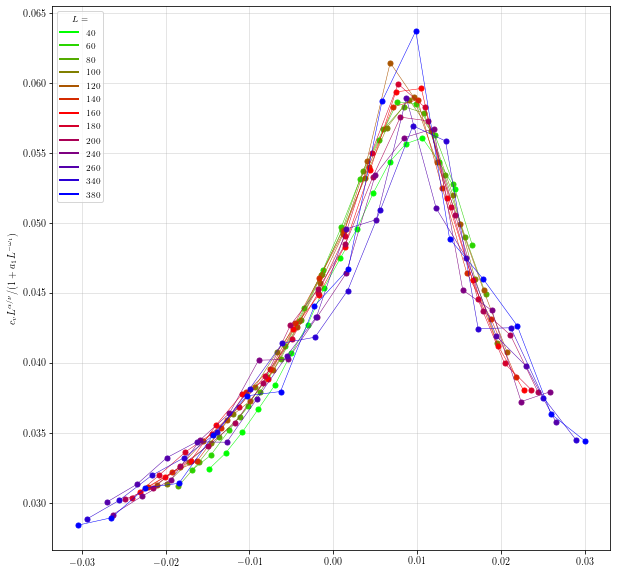

In [4]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import division
import numpy as np
from numpy.random import rand
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import math
import sys
import os
from random import shuffle
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fmin
from scipy.optimize import fsolve
from scipy import interpolate
from scipy.optimize import curve_fit
import scipy.optimize as opt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.signal import savgol_filter
from random import gauss
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#ipython specific

%matplotlib inline


from matplotlib import rc
rc('font',**{'family':'sans-serif', 'size' : 10}) #, 'sans-serif':['Arial']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

color_red = (0.73, 0.13869999999999993, 0.)
color_orange = (1., 0.6699999999999999, 0.)
color_green = (0.14959999999999996, 0.43999999999999995, 0.12759999999999994)
color_blue = (0.06673600000000002, 0.164512, 0.776)
color_purple = (0.25091600000000003, 0.137378, 0.29800000000000004)
color_ocker = (0.6631400000000001, 0.71, 0.1491)
color_pink = (0.71, 0.1491, 0.44730000000000003)
color_brown = (0.651, 0.33331200000000005, 0.054683999999999955)

color_all = [color_red, color_orange, color_green, color_blue, color_purple, color_ocker,color_pink, color_brown]


from funcfssa import autoscale, scaledata   #usual scaling
from funcfssa2 import autoscale2, scaledata2  #correction in y
#from funcfssa3 import autoscale3, scaledata3  #added correction in x
#from funcfssa4 import autoscale4, scaledata4  #added correction in x


j2 = 1.0
j6 = 1.0
Kc = 0.0
lambda3 = 2.1
q_Q = 1
offset = 0
N_og = [40, 60, 80, 100, 120, 140, 160, 180, 200, 240, 260, 340, 380]
#N_og = [40, 60, 80, 100, 120, 140, 160, 180, 200]
N_list = N_og

#N_fit_cv = 200
N_fit_cv = 300
####
#code
###

cv_ind = 1
chi_ind = 10 #for chi_sigma
m_ind = 9 #for m_sigma


data = np.load('Delta1_data_v2.npy',allow_pickle=True)


######
#-----------------------------------------------------------------------------------------------------------------------
#######
#parameters of the code
######
#-----------------------------------------------------------------------------------------------------------------------
######



#size_investigate = [20, 32]
Blocks = ['*','o', 'v', 'd','s','+', 'x']
#colors_size = ['blue', 'red', 'green', 'brown']

cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='brg_r')
#scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis_r')
colors_size = [scalarMap.to_rgba(i/(len(N_list)-1)) for i in range(len(N_list))]
#colors_size = [scalarMap.to_rgba(i/(len(N_og)-1)) for i in range(len(N_og))]


### scaling of specific heat
###

ls = N_list
a_arr = []
da_arr = []
flat_temp = []
ind = cv_ind  #here choose your fit
scaleC = 1

#take temp range of L=380 as the basic range of temperature for all of them
rhos = np.array(data[-1][0])

#for each system size L, download the data, and creat interpolation function.
#use rhos (the T list) for all of them to get the interpolated values for CV (a_arr)
#da_arr is a bogus list - could reduce 0.01 by a lot if needed.
for i in range(len(N_list)):
    i_og = i + offset
    prelim_y = (N_list[i]**(2*scaleC))*data[i_og][2*ind + 1]
    prelim_x = data[i_og][0] 
    
    spl_alt = InterpolatedUnivariateSpline(prelim_x, prelim_y, k=5)
    
    a_arr.append(spl_alt(rhos))
    da_arr.append(0.01*spl_alt(rhos))

a_arr = np.array(a_arr)
da_arr = np.array(da_arr)

# scaling function ansatz autoscale (no corrections to scaling) or autoscale2 (corrections to scaling on x or y) or autoscale3 (corrections to scaling on both x and y)
print('\nSpecific heat: initial values')
print('(Tc, nu, beta, beta/nu) = (1.2035, 0.83, 0.33, 0.4)')

#choose how you want to do the scaling
scale = 3
do_fit = True
#values obtained by previous fits
vals = [ 1.202, 1.8, 0.76, 0.31, 100, 0.0, 0.0] #good fit, alpha/nu ~ 0.4 like it should
#if you want the actual values for nu and alpha, but try to only fit the corrections, you probably get
#vals = [ 1.202, 0.83, 0.33, 0.85, 23.0, 0.0, 0.0]
#or this
#vals = [ 1.202, 0.9, 0.4, 0.7, 20.0, 0.0, 0.0]

print(ls)


if do_fit:

    if scale == 3:
        # [Tc, nu, \gamma, a1, \omega_1, a2, \omega_2]
        init_guess = [1.2, 5/6, 1/3, 0.1, 100, 0.1, 100]

        noisy_ret = autoscale3(ls, rhos, a_arr, da_arr, *init_guess)
        print('CV:')
        print('values: Tc, nu, zeta, omega1, a1, omega2, a2')
        print(noisy_ret['x'])
        print('errors')
        print(noisy_ret['errors'])

        noisy_auto_scaled_data =scaledata3(ls, rhos, a_arr, da_arr, *noisy_ret['x'])



    elif scale == 2:

        init_guess = [1.2, 5/6, 1/3, 0.1, 0.1]

        noisy_ret = autoscale2(ls, rhos, a_arr, da_arr, *init_guess)
        print('CV:')
        print('values: Tc, nu, zeta, omega, a')
        print(noisy_ret['x'])
        print('errors')
        print(noisy_ret['errors'])

        noisy_auto_scaled_data =scaledata2(ls, rhos, a_arr, da_arr, *noisy_ret['x'])


    elif scale == 1:

        init_guess = [1.2, 5/6, 1/3]

        noisy_ret = autoscale(ls, rhos, a_arr, da_arr, *init_guess)
        print('CV:')
        print('values: Tc, nu, zeta')
        print(noisy_ret['x'])
        print('errors')
        print(noisy_ret['errors'])

        noisy_auto_scaled_data =scaledata(ls, rhos, a_arr, da_arr, *noisy_ret['x'])
        
    elif scale == 4:

        init_guess = [0.1, 0.1, 0.1, 0.1]

        noisy_ret = autoscale4(ls, rhos, a_arr, da_arr, *init_guess)
        print('CV:')
        print('values: omega1, a1, omega2, a2')
        print(noisy_ret['x'])
        print('errors')
        print(noisy_ret['errors'])

        noisy_auto_scaled_data =scaledata4(ls, rhos, a_arr, da_arr, *noisy_ret['x'])

else:

    noisy_auto_scaled_data = scaledata3(ls, rhos, a_arr, da_arr, *vals)


#the values obtained by the fit
#[Tc, nu, alpha] = noisy_ret['x'][0:3]

#########
#--------
#########
#the figure environment

fig = plt.figure(figsize = (10,10) )
ax1 = plt.subplot()

#specific heat
for i in range(len(N_list)):
    #hand test
    #if you want to use your own values from vals, use next line
    #noisy_auto_scaled_data = scaledata3(ls, rhos, a_arr, da_arr, *vals)
    
    y_val = (noisy_auto_scaled_data.y.T)[:,i]
    x_val = (noisy_auto_scaled_data.x.T)[:,i]

    ax1.plot(x_val, y_val, marker ='o', markersize = 5, linestyle = '-', linewidth = 0.5,  color=colors_size[i])

#ax1.set_xlabel(r"$(T - T_{3})L^{1/\nu}/(1 + a_2 L^{-\omega_2})$", fontsize=10);
ax1.set_ylabel(r'$c_{v}L^{\alpha/\nu}/(1 + a_1 L^{-\omega_1})$ ', fontsize=10);

# ax1.set_xlabel(r"$\tilde{t} = (T - T_{potts})L^{1/\nu} (1 + a_2 L^{-\omega_2})^{-1}$", fontsize=10);
# ax1.set_ylabel(r'Scaled Specific Heat $\tilde{c}_{v} = L^{\beta/\nu} c_{v} (1 + a_1 L^{-\omega_1})^{-1}$ ', fontsize=10);


#do the legend and append at the end
# patches_lg = []
# for i in range(len(N_list)):
#     patches_lg.append(patches.Patch(color=colors_size[i], label='L='+str(int(N_list[i]))))
#ax.legend(handles=patches_lg, loc='upper right', bbox_to_anchor=(0.98,0.95), ncol=1,fontsize = 10)

patches_lg = []
for i in range(len(N_list)):
    patches_lg.append(Line2D([0], [0], color=colors_size[i], linewidth = 2, linestyle = '-', label='$'+str(int(N_list[i]))+'$') )
ax1.legend(handles=patches_lg, loc='upper left', title = '$L = $', title_fontsize = 9, ncol=1, fontsize = 9)

ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.grid(which='major', axis='both', linestyle='-', alpha = 0.4)
ax1.grid(which='minor', axis='both', linestyle='-', alpha = 0.2)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.tick_params(axis='both', which='minor', labelsize=10)



#plt.savefig('./scaleCV.png', format='png', dpi = 100, bbox_inches='tight')
plt.show()


In [48]:
#a function that returns the cv scaling plot only
#easy to play with vals and see the result
def figure_noscale():

    fig = plt.figure(figsize = (10,10) )
    ax1 = plt.subplot()

    #specific heat
    for i in range(len(N_list)):
        #hand test
        
        y_val = a_arr[i]
        x_val = rhos

        ax1.plot(x_val, y_val, marker ='o', markersize = 5, linestyle = '-', linewidth = 0.5,  color=colors_size[i])

    ax1.set_xlabel(r"$(T - T_{3})L^{1/\nu}/(1 + a_2 L^{-\omega_2})$", fontsize=10);
    ax1.set_ylabel(r'$c_{v}L^{\alpha/\nu}/(1 + a_1 L^{-\omega_1})$ ', fontsize=10);

    # ax1.set_xlabel(r"$\tilde{t} = (T - T_{potts})L^{1/\nu} (1 + a_2 L^{-\omega_2})^{-1}$", fontsize=10);
    # ax1.set_ylabel(r'Scaled Specific Heat $\tilde{c}_{v} = L^{\beta/\nu} c_{v} (1 + a_1 L^{-\omega_1})^{-1}$ ', fontsize=10);


    #do the legend and append at the end
    # patches_lg = []
    # for i in range(len(N_list)):
    #     patches_lg.append(patches.Patch(color=colors_size[i], label='L='+str(int(N_list[i]))))
    #ax.legend(handles=patches_lg, loc='upper right', bbox_to_anchor=(0.98,0.95), ncol=1,fontsize = 10)

    patches_lg = []
    for i in range(len(N_list)):
        patches_lg.append(Line2D([0], [0], color=colors_size[i], linewidth = 2, linestyle = '-', label='$'+str(int(N_list[i]))+'$') )
    ax1.legend(handles=patches_lg, loc='upper left', title = '$L = $', title_fontsize = 9, ncol=1, fontsize = 9)

    ax1.xaxis.set_minor_locator(MultipleLocator(5))
    ax1.grid(which='major', axis='both', linestyle='-', alpha = 0.4)
    ax1.grid(which='minor', axis='both', linestyle='-', alpha = 0.2)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.tick_params(axis='both', which='minor', labelsize=10)



    #plt.savefig('./scaleCV.png', format='png', dpi = 100, bbox_inches='tight')
    plt.show()

    return

def figure_fit(vals):

    fig = plt.figure(figsize = (10,10) )
    ax1 = plt.subplot()

    #specific heat
    for i in range(len(N_list)):
        #hand test

        noisy_auto_scaled_data =scaledata3(ls, rhos, a_arr, da_arr, *vals)
        y_val = (noisy_auto_scaled_data.y.T)[:,i]
        x_val = (noisy_auto_scaled_data.x.T)[:,i]


        ax1.plot(x_val, y_val, marker ='o', markersize = 5, linestyle = '-', linewidth = 0.5,  color=colors_size[i])

    ax1.set_xlabel(r"$(T - T_{3})L^{1/\nu}/(1 + a_2 L^{-\omega_2})$", fontsize=10);
    ax1.set_ylabel(r'$c_{v}L^{\alpha/\nu}/(1 + a_1 L^{-\omega_1})$ ', fontsize=10);

    # ax1.set_xlabel(r"$\tilde{t} = (T - T_{potts})L^{1/\nu} (1 + a_2 L^{-\omega_2})^{-1}$", fontsize=10);
    # ax1.set_ylabel(r'Scaled Specific Heat $\tilde{c}_{v} = L^{\beta/\nu} c_{v} (1 + a_1 L^{-\omega_1})^{-1}$ ', fontsize=10);


    #do the legend and append at the end
    # patches_lg = []
    # for i in range(len(N_list)):
    #     patches_lg.append(patches.Patch(color=colors_size[i], label='L='+str(int(N_list[i]))))
    #ax.legend(handles=patches_lg, loc='upper right', bbox_to_anchor=(0.98,0.95), ncol=1,fontsize = 10)

    patches_lg = []
    for i in range(len(N_list)):
        patches_lg.append(Line2D([0], [0], color=colors_size[i], linewidth = 2, linestyle = '-', label='$'+str(int(N_list[i]))+'$') )
    ax1.legend(handles=patches_lg, loc='upper left', title = '$L = $', title_fontsize = 9, ncol=1, fontsize = 9)

    ax1.xaxis.set_minor_locator(MultipleLocator(5))
    ax1.grid(which='major', axis='both', linestyle='-', alpha = 0.4)
    ax1.grid(which='minor', axis='both', linestyle='-', alpha = 0.2)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax1.tick_params(axis='both', which='minor', labelsize=10)



    #plt.savefig('./scaleCV.png', format='png', dpi = 100, bbox_inches='tight')
    plt.show()

    return

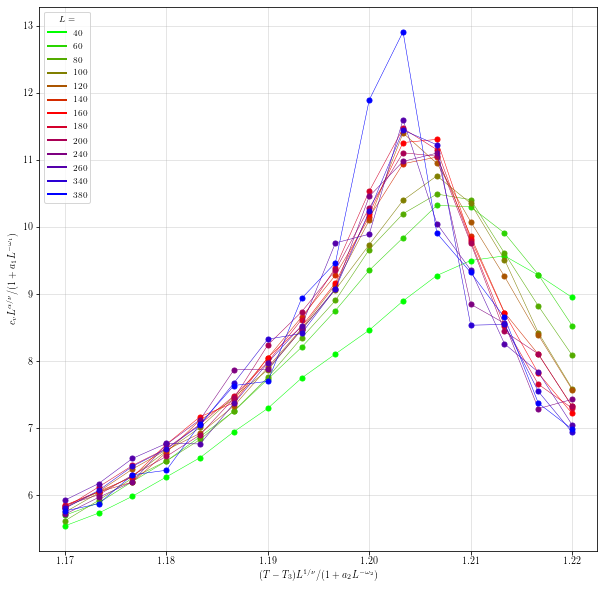

In [29]:
#no scaling
figure_noscale()

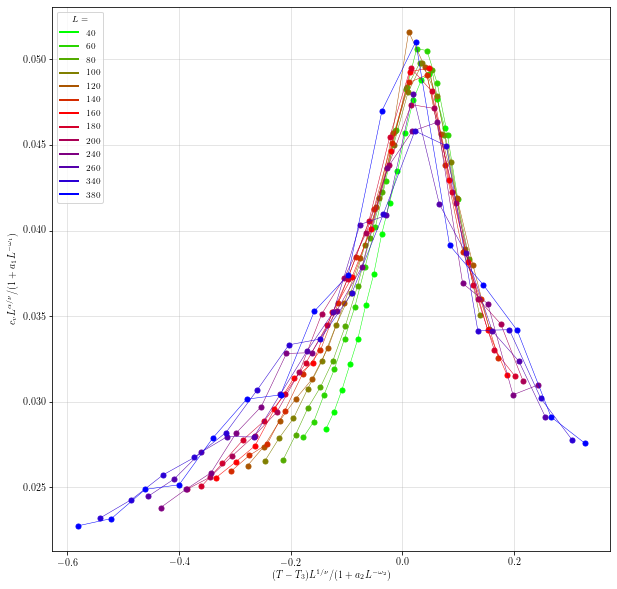

In [86]:
#Tc, nu, alpha, omega1, a1, omega2, a2
#testV = [ 1.202, 1.8, 0.76, 0.31, 100, 0.0, 0.0]
#testV = [ 1.202, 2.0, 0.4, 10.0, 3.0, 0.4, 0.1]
testV = [ 1.202,  1.66,  0.66,  0.29,  128.0,  0.7*0.11640164, 3*0.52590368]
#[ 1.19519061e+00  2.74970795e+00  5.93925711e-01  1.41637842e-01  1.28070575e+02 -4.90546974e-02  4.60528951e+00]
#print("alpha/nu = ", testV[2]/testV[1])
figure_fit(testV)

In [87]:
0.7*0.11640164

0.08148114799999999